# Using `FlowAccumulator` and `KinwaveImplicitOverlandFlow` to route flow over a rutted road surface

The following components are not newly developed in the Landlab modeling framework, but they are essential to running a full-scale road erosion model. This tutorial walks through how to use both the `FlowAccumulator` component and the `KinwaveImplicitOverlandFlow` component to route flow over our rutted road surface created using `TruckPassErosion`.

## Load necessary `python` packages and set some defaults

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

from landlab import RasterModelGrid 
from landlab.io import native_landlab
from landlab.components import KinwaveImplicitOverlandFlow, FlowAccumulator
from landlab.plot.imshow import imshow_grid
from landlab.plot.drainage_plot import drainage_plot

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'normal'

## Load pre-rutted Landlab grid and define some variables

In [2]:
mg = native_landlab.load_grid('rutted_grid.grid')
z = mg.at_node['topographic__elevation']
n = mg.at_node['roughness']

ditch_id = np.argmin(z[0:8]) 
rut_left_id = 31
rut_right_id = 49

X = mg.node_x.reshape(mg.shape)
Y = mg.node_y.reshape(mg.shape)
Z = z.reshape(mg.shape)

xsec_active = mg.at_node['active__elev'][4392*2:4428*2]
xsec_surf =  mg.at_node['surfacing__elev'][4392*2:4428*2] 
xsec_ball = mg.at_node['ballast__elev'][4392*2:4428*2]

## Visualizations of the rutted road

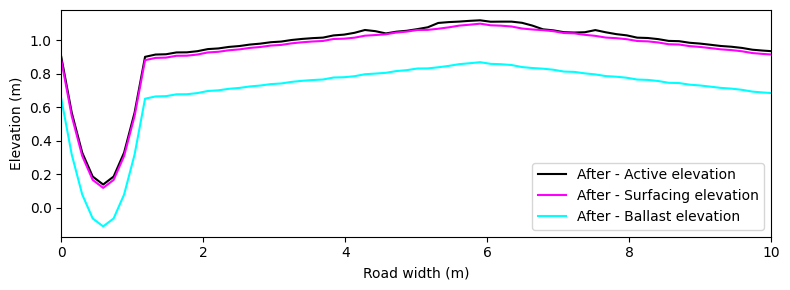

In [3]:

plt.figure(figsize=(8,3), layout='tight')
plt.plot(X[36], xsec_active, color ='black', linestyle='-', label = 'After - Active elevation')
plt.plot(X[36], xsec_surf, color ='magenta', linestyle='-', label = 'After - Surfacing elevation')
plt.plot(X[36], xsec_ball, color ='cyan', linestyle='-', label = 'After - Ballast elevation ')
plt.xlim(0,10)
plt.xlabel('Road width (m)')
plt.ylabel('Elevation (m)')
plt.legend()
plt.show()


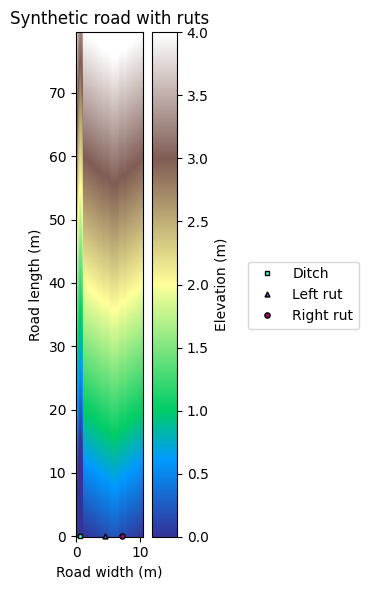

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 6))
imshow_grid(mg, z, plot_name='Synthetic road with ruts', var_name='Elevation', var_units='m',\
    grid_units=('m', 'm'), cmap='terrain', color_for_closed='black', vmin=0, vmax=4)
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')

# Plot the sample nodes.
plt.plot(mg.node_x[ditch_id], mg.node_y[ditch_id], 's', zorder=10, ms=3.5, \
    clip_on=False, color='#44FFD1', markeredgecolor='k', label='Ditch')
plt.plot(mg.node_x[rut_left_id], mg.node_y[rut_left_id], '^', zorder=10, ms=3.5, \
    clip_on=False, color='#6153CC', markeredgecolor='k', label='Left rut')
plt.plot(mg.node_x[rut_right_id], mg.node_y[rut_right_id], 'o', zorder=10, ms=3.75, \
    clip_on=False, color='#A60067', markeredgecolor='k',label='Right rut')

_ = ax.legend(loc='center right', bbox_to_anchor=(1.25,0.5), \
    bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.show()

## Using `FlowAccumulator` to route flow at steady state

Here, we want to instantiate Landlab's `FlowAccumulator` using 'MFD' as the flow director, the runoff rate in m/s, and the partition method 'square_root_of_slope' to match the instantiation of `FlowAccumulator` in the `KinwaveImplicitOverlandFlow` component (since we're going to do some comparisons).

In [5]:
fa = FlowAccumulator(mg,
                     surface='topographic__elevation',
                     flow_director='MFD', #multiple flow directions
                     runoff_rate=1.66667e-6, #6 mm/hr converted to m/s
                     partition_method='square_root_of_slope')

FlowAccumulator found both the field 'water__unit_flux_in' and a provided float or array for the runoff_rate argument. THE FIELD IS BEING OVERWRITTEN WITH THE SUPPLIED RUNOFF_RATE!


Run the `accumulate_flow` method to get drainage area and discharge at each node.

In [6]:
(drainage_area, discharge) = fa.accumulate_flow()

As a quick check, we want to see how many of the core nodes are sinks and only use the DEM if less thn 1% of the core nodes are sinks. (For this example, the DEM should have 0 core nodes as sinks since we created our own relatively flat DEM.)

In [7]:
# Check to see how many of the core nodes are sinks
sinks = mg.at_node['flow__sink_flag'][mg.core_nodes].sum()

if sinks < 0.01*mg.core_nodes.sum():
    print(sinks, r'of the core nodes are sinks. This is less than 1% of the core nodes. Code can continue.')
else:
    print(sinks, r'of the core nodes are sinks. This is more than 1% of the core nodes. \
        Consider using a DEM that has been pre-processed for sinks.')

0 of the core nodes are sinks. This is less than 1% of the core nodes. Code can continue.


Next, we'll determine the discharge at each of the previously defined outlet locations in $m^3/s$. We'll compare these values to what we obtain from `KinwaveImplicitOverlandFlow`.

In [8]:
# Obtain discharge at the ditch, left rut, and right rut nodes in m^3/s
discharge_ditch = mg.at_node['surface_water__discharge'][ditch_id]
discharge_rut_left= mg.at_node['surface_water__discharge'][rut_left_id]
discharge_rut_right = mg.at_node['surface_water__discharge'][rut_right_id]

print('Ditch discharge (m^3/s) =', np.round(discharge_ditch,5))
print('Left rut discharge (m^3/s) =', np.round(discharge_rut_left,5))
print('Right rut discharge (m^3/s) =', np.round(discharge_rut_right,5))

Ditch discharge (m^3/s) = 0.00055
Left rut discharge (m^3/s) = 0.00021
Right rut discharge (m^3/s) = 0.00021


And we can plot a map of surface water discharge at steady state (i.e., when the outlets have maximum discharge).

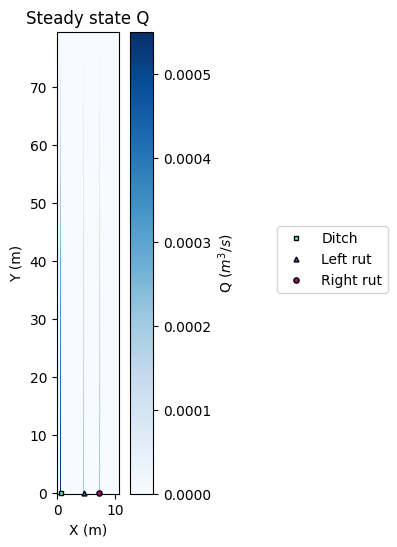

In [9]:
# Map surface water discharge when outlet is at its maximum
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 6))
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
imshow_grid(mg,'surface_water__discharge', plot_name='Steady state Q', 
            var_name='Q', var_units='$m^3/s$', grid_units=('m','m'), 
            cmap='Blues', vmin=0, vmax=0.00055)

# Plot the sample nodes.
plt.plot(mg.node_x[ditch_id], mg.node_y[ditch_id], 's', zorder=10, ms=3.5, \
    clip_on=False, color='#44FFD1', markeredgecolor='k', label='Ditch')
plt.plot(mg.node_x[rut_left_id], mg.node_y[rut_left_id], '^', zorder=10, ms=3.5, \
    clip_on=False, color='#6153CC', markeredgecolor='k', label='Left rut')
plt.plot(mg.node_x[rut_right_id], mg.node_y[rut_right_id], 'o', zorder=10, ms=3.75, \
    clip_on=False, color='#A60067', markeredgecolor='k',label='Right rut')

_ = ax.legend(loc='center left', bbox_to_anchor=(1.25,0.5), \
    bbox_transform=plt.gcf().transFigure)

## Using `KinwaveImplicitOverlandFlow` to route flow

Here, we instantiate `KinwaveImplicitOverlandFlow` using the same runoff rate as was used in our `FlowAccumulator` instantiation.

In [10]:
knwv = KinwaveImplicitOverlandFlow(mg, runoff_rate=6, roughness=n, depth_exp=5/3) #Feed initial component a runoff rate of 6 mm/hr

Then, we initialize some model run parameters.

In [11]:
# Initialize model run information
hydrograph_time = [0]
discharge_ditch = [0]
discharge_rut_left = [0]
discharge_rut_right = [0]
discharge_road_right = [0]
dt = 60 #time step in seconds

run_time_slices = (1,601,1801,2401,3601)
elapsed_time = 1 #Set an initial time to avoid any 0 errors
storm_duration = 2701 #length of storm in seconds; 45 min
model_run_time = 3601 #total model run time

We can now run the model! We'll run the model for 1 hour, where the storm is 45 minutes in duration. While the storm is happening, the runoff rate will remain steady at 6 mm/hr, but beyond the storm duration, the runoff rate will reset to 0 mm/hr. We'll generate maps of surface water discharge at 10-minute intervals to see the progression of the storm being routed over the DEM.

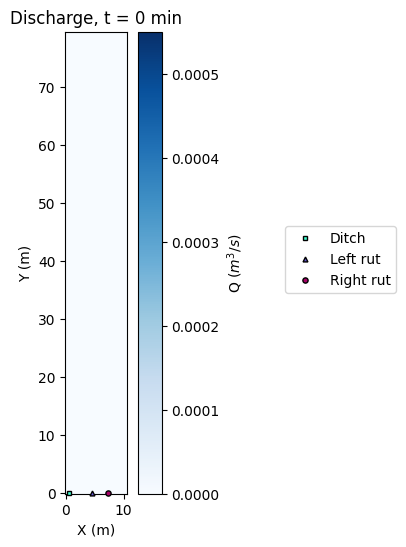

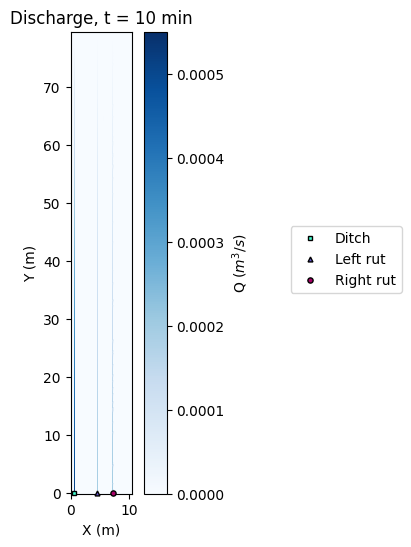

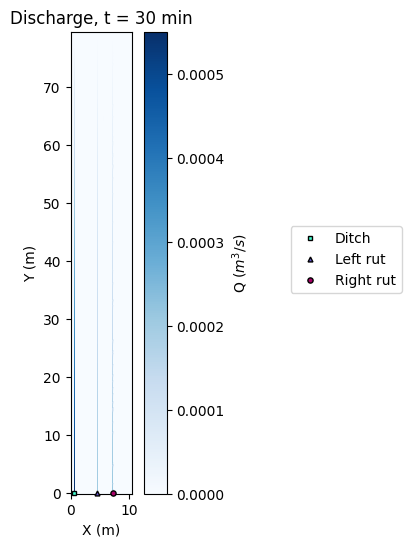

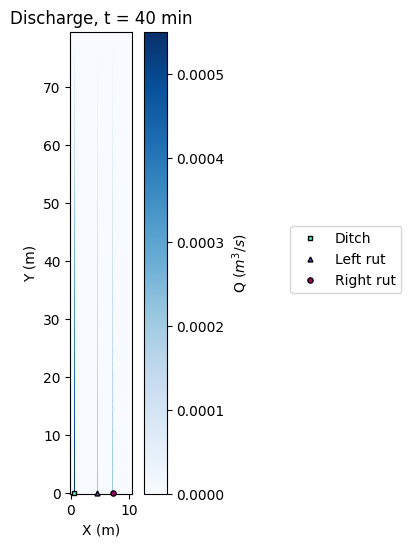

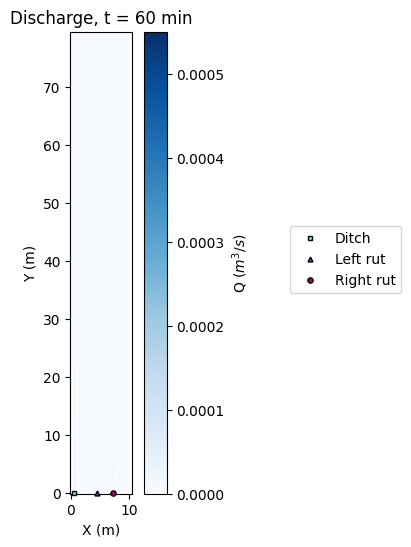

Time taken to run the code was 177.6519763469696 seconds


In [12]:
# Run the model; note that this will take a bit of time!
start = time.time()

while elapsed_time <= model_run_time:
    if elapsed_time < storm_duration:
        knwv.run_one_step(dt)
    else:
        knwv.runoff_rate = 1e-30 #Reset runoff_rate to be ~0; post-storm runoff
        knwv.run_one_step(dt)

    for t in run_time_slices:
        if elapsed_time == t:
            time_model = t/60 
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 6))
            imshow_grid(mg, 'surface_water_inflow__discharge', plot_name='Discharge, t = %i min' % time_model, 
                var_name='Q', var_units='$m^3/s$', grid_units=('m','m'), vmin=0, vmax=0.00055,
                cmap='Blues')
            # Plot the sample nodes.
            plt.plot(mg.node_x[ditch_id], mg.node_y[ditch_id], 's', zorder=10, ms=3.5, \
                clip_on=False, color='#44FFD1', markeredgecolor='k', label='Ditch')
            plt.plot(mg.node_x[rut_left_id], mg.node_y[rut_left_id], '^', zorder=10, ms=3.5, \
                clip_on=False, color='#6153CC', markeredgecolor='k', label='Left rut')
            plt.plot(mg.node_x[rut_right_id], mg.node_y[rut_right_id], 'o', zorder=10, ms=3.75, \
                clip_on=False, color='#A60067', markeredgecolor='k',label='Right rut')

            _ = ax.legend(loc='center left', bbox_to_anchor=(1.25,0.5), \
                bbox_transform=plt.gcf().transFigure)
            plt.show()

    q_ditch = mg.at_node['surface_water_inflow__discharge'][ditch_id].item() 
    q_rut_left = mg.at_node['surface_water_inflow__discharge'][rut_left_id].item() 
    q_rut_right = mg.at_node['surface_water_inflow__discharge'][rut_right_id].item() 

    hydrograph_time.append(elapsed_time/3600.)

    discharge_ditch.append(q_ditch)
    discharge_rut_left.append(q_rut_left)
    discharge_rut_right.append(q_rut_right) 
                        
    elapsed_time += dt #increase model time
            

end = time.time()
print(f"Time taken to run the code was {end-start} seconds")

Using the information from the model run, we can plot the outlet hydrographs for the ditch outlet, the left rut outlet, and the right rut outlet.

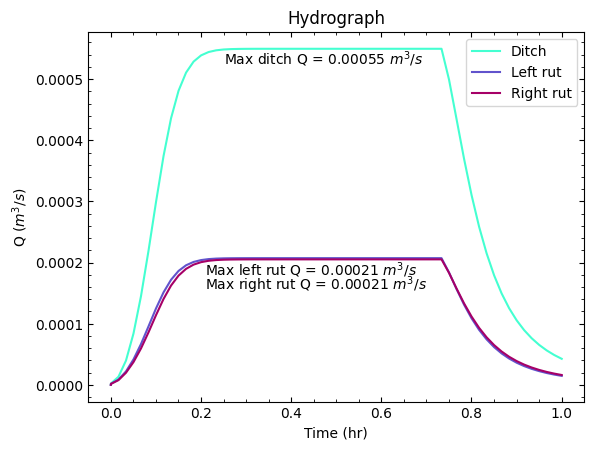

In [13]:
#Plot the hydrograph
ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in', bottom='on', 
               left='on', top='on', right='on')
ax.minorticks_on()

ax.plot(hydrograph_time, discharge_ditch, '-', color='#44FFD1', markeredgecolor='k', label='Ditch')
ax.plot(hydrograph_time, discharge_rut_left, '-', color='#6153CC', markeredgecolor='k', label='Left rut')
ax.plot(hydrograph_time, discharge_rut_right, '-', color='#A60067', markeredgecolor='k',label='Right rut')
ax.set(xlabel='Time (hr)', ylabel='Q ($m^3/s$)',
        title='Hydrograph')
ax.annotate('Max ditch Q = ' + str(np.max(np.round(discharge_ditch,5))) + ' $m^3/s$',(0.25,0.000525))
ax.annotate('Max left rut Q = ' + str(np.max(np.round(discharge_rut_left,5))) + ' $m^3/s$',(0.21,0.00018))
ax.annotate('Max right rut Q = ' + str(np.max(np.round(discharge_rut_right,5))) + ' $m^3/s$',(0.21,0.000155))
_=ax.legend()
plt.show()


The maximum value of each outlet's discharge matches the steady-state discharge obtained from `FlowAccumulator`, so we can feel confident that both `FlowAccumulator` and `KinwaveImplicitOverlandFlow` are yielding the same results. 

In summary, both components are valuable tools that have different advantages/disadvantages:
- `FlowAccumulator` provides fast, easy flow routing at the system's steady state but cannot provide a timeseries evolution of the flow.
- `KinwaveImplicitOverlandFlow` provides the timeseries evolution of the flow, taking into consideration physical characteristics of the road such as roughness, but takes a much longer time to run.